# Installing Libraries

In [55]:
!pip install -U imbalanced-learn
!pip install tensorflow

# Importing Libraries




In [56]:
# Core Libraries
import numpy as np
import pandas as pd
import textwrap
from collections import Counter
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Scikit-learn (Data Prep & Evaluation)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,
    LSTM, TimeDistributed
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model



# Signal Processing
from scipy.fft import fft, fftfreq


# Loading Dataset

In [57]:
file_pairs = [
    ("/content/drive/MyDrive/iot_dataset/BenignTraffic.csv",
     "/content/drive/MyDrive/iot_dataset/BenignTraffic.pcap_Flow.csv",
     "Benign"),

    ("/content/drive/MyDrive/iot_dataset/DoS-HTTP_Flood.csv",
     "/content/drive/MyDrive/iot_dataset/DoS-HTTP_Flood.pcap_Flow.csv",
     "DoS"),

    ("/content/drive/MyDrive/iot_dataset/DDoS-ACK_Fragmentation.csv",
     "/content/drive/MyDrive/iot_dataset/DDoS-ACK_Fragmentation.pcap_Flow.csv",
     "DDoS"),

    ("/content/drive/MyDrive/iot_dataset/DDoS-HTTP_Flood.csv",
     "/content/drive/MyDrive/iot_dataset/DDoS-HTTP_Flood.pcap_Flow.csv",
     "DDoS"),

    ("/content/drive/MyDrive/iot_dataset/DictionaryBruteForce.csv",
     "/content/drive/MyDrive/iot_dataset/DictionaryBruteForce.pcap_Flow.csv",
     "BruteForce"),

    ("/content/drive/MyDrive/iot_dataset/Uploading_Attack.csv",
     "/content/drive/MyDrive/iot_dataset/Uploading_Attack.pcap_Flow.csv",
     "Web-based"),

    ("/content/drive/MyDrive/iot_dataset/XSS.csv",
     "/content/drive/MyDrive/iot_dataset/XSS.pcap_Flow.csv",
     "Web-based"),

    ("/content/drive/MyDrive/iot_dataset/SqlInjection.csv",
     "/content/drive/MyDrive/iot_dataset/SqlInjection.pcap_Flow.csv",
     "Web-based"),

    ("/content/drive/MyDrive/iot_dataset/VulnerabilityScan.csv",
     "/content/drive/MyDrive/iot_dataset/VulnerabilityScan.pcap_Flow.csv",
     "Scan")
]

# Store all merged DataFrames in a dictionary
merged_dfs = {}

for packet_path, flow_path, attack_label in file_pairs:
    print(f"Processing: {attack_label}")
    packet = pd.read_csv(packet_path, nrows=1000000, low_memory=False)
    flow = pd.read_csv(flow_path, nrows=1000000, low_memory=False)

    # Normalize columns
    packet.columns = packet.columns.str.lower().str.strip()
    flow.columns = flow.columns.str.lower().str.strip()

    # Drop duplicates on merge keys
    packet = packet.drop_duplicates(['src_ip', 'dst_ip', 'src_port', 'dst_port'])
    flow = flow.drop_duplicates(['src ip', 'dst ip', 'src port', 'dst port'])

    # Merge
    merged = pd.merge(
        packet,
        flow,
        left_on=['src_ip', 'dst_ip', 'src_port', 'dst_port'],
        right_on=['src ip', 'dst ip', 'src port', 'dst port'],
        how='inner',
        suffixes=('_packet', '_flow')
    )

    # Force label to attack name
    merged['label'] = attack_label

    # Store in the dictionary
    merged_dfs[attack_label] = merged
    print(f"Added {attack_label}: {merged.shape[0]} rows")

#print(merged_dfs['BenignTraffic'].head())
#print(merged_dfs['DoS-HTTP_Flood'].head())
#print(merged_dfs['DDoS-ACK_Fragmentation'].head())
#print(merged_dfs['DictionaryBruteForce'].head())
#print(merged_dfs['Uploading_Attack'].head())
#print(merged_dfs['VulnerabilityScan'].head())

all_attacks_df = pd.concat(list(merged_dfs.values()), ignore_index=True)
print("Shape of combined dataframe:", all_attacks_df.shape)


Processing: Benign
Added Benign: 24754 rows
Processing: DoS
Added DoS: 10602 rows
Processing: DDoS
Added DDoS: 19260 rows
Processing: DDoS
Added DDoS: 23979 rows
Processing: BruteForce
Added BruteForce: 3505 rows
Processing: Web-based
Added Web-based: 995 rows
Processing: Web-based
Added Web-based: 2063 rows
Processing: Web-based
Added Web-based: 4705 rows
Processing: Scan
Added Scan: 57974 rows
Shape of combined dataframe: (125519, 219)


In [58]:
all_attacks_df.head()

stream                       src_mac            dst_mac           src_ip  \
0       0          Arlo Q Indoor Camera  3c:18:a0:41:c3:a0  192.168.137.175   
1       0  HeimVision Smart WiFi Camera  01:00:5e:7f:ff:fa   192.168.137.90   
2       1            Nest Indoor Camera  3c:18:a0:41:c3:a0   192.168.137.46   
3       2             ac:17:02:05:34:27  3c:18:a0:41:c3:a0   192.168.137.41   
4       1                 Teckin Plug 2  ff:ff:ff:ff:ff:ff   192.168.137.82   

            dst_ip  src_port  dst_port  inter_arrival_time  \
0     99.81.244.93     56891       443            0.000000   
1  239.255.255.250     37020     37000            0.018635   
2    35.185.101.66     48335       443            0.020436   
3   157.249.81.141     50093       443            0.117614   
4  255.255.255.255     49236      6667            0.122046   

   time_since_previously_displayed_frame  port_class_dst  ...  \
0                               0.000000               1  ...   
1                               0.010462               2  ...   
2                               0.000357               1  ...   
3                               0.097176               1  ...   
4                               0.002378               2  ...   

   fwd seg size min  active mean  active std  active max  active min  \
0                32          0.0         0.0         0.0         0.0   
1                 8          0.0         0.0         0.0         0.0   
2                32          0.0         0.0         0.0         0.0   
3                32          0.0         0.0         0.0         0.0   
4                 8          0.0         0.0         0.0         0.0   

      idle mean       idle std   idle max   idle min   label  
0  0.000000e+00       0.000000        0.0        0.0  Benign  
1  6.308231e+06  732303.605535  8438944.0  6010033.0  Benign  
2  0.000000e+00       0.000000        0.0        0.0  Benign  
3  0.000000e+00       0.000000        0.0        0.0  Benign  
4  5.322671e+06   63203.867364  5472359.0  5236127.0  Benign  

[5 rows x 219 columns]

In [59]:
all_attacks_df.tail()

stream            src_mac                           dst_mac  \
125514    6920  3c:18:a0:41:c3:a0                 ac:17:02:05:34:27   
125515   80383  ac:17:02:05:34:27                 3c:18:a0:41:c3:a0   
125516    6921  3c:18:a0:41:c3:a0           Borun/Sichuan-AI Camera   
125517    6922  3c:18:a0:41:c3:a0  harman kardon (Ampak Technology)   
125518   80383  3c:18:a0:41:c3:a0                 ac:17:02:05:34:27   

                src_ip           dst_ip  src_port  dst_port  \
125514   192.168.137.1   192.168.137.41        53     45472   
125515  192.168.137.41   157.249.81.141     45145       443   
125516   192.168.137.1  192.168.137.163        53     45470   
125517   192.168.137.1  192.168.137.177        53     42631   
125518  157.249.81.141   192.168.137.41       443     45145   

        inter_arrival_time  time_since_previously_displayed_frame  \
125514        24832.720267                               0.003565   
125515        24832.743425                               0.003463   
125516        24832.747324                               0.003899   
125517        24832.748245                               0.000921   
125518        24832.868350                               0.028766   

        port_class_dst  ...  fwd seg size min  active mean  active std  \
125514               2  ...                 8          0.0         0.0   
125515               1  ...                32          0.0         0.0   
125516               2  ...                 8          0.0         0.0   
125517               2  ...                 8          0.0         0.0   
125518               2  ...                40          0.0         0.0   

        active max  active min  idle mean idle std  idle max  idle min  label  
125514         0.0         0.0        0.0      0.0       0.0       0.0   Scan  
125515         0.0         0.0        0.0      0.0       0.0       0.0   Scan  
125516         0.0         0.0        0.0      0.0       0.0       0.0   Scan  
125517         0.0         0.0        0.0      0.0       0.0       0.0   Scan  
125518         0.0         0.0        0.0      0.0       0.0       0.0   Scan  

[5 rows x 219 columns]

# Data Pre-processing

## Checking for Duplicate Values

In [60]:
num_duplicates = all_attacks_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Checking for Missing Values

In [61]:
missing_counts = all_attacks_df.isnull().sum()
print("\nMissing values per column (top 20):")
print(missing_counts.sort_values(ascending=False).head(50))


Missing values per column (top 20):
stream_jitter_1_var           116009
stream_jitter_5_var           114562
stream_1_var                  114431
stream_jitter_10_var          114198
stream_jitter_30_var          113508
stream_jitter_60_var          112946
stream_5_var                  112635
stream_10_var                 112199
stream_30_var                 111426
stream_60_var                 110750
dns_query_type                104015
jitter                         95815
stream_jitter_10_sum           95815
stream_jitter_1_sum            95815
stream_jitter_1_mean           95815
stream_jitter_30_sum           95815
stream_jitter_10_mean          95815
stream_jitter_5_sum            95815
stream_jitter_5_mean           95815
stream_jitter_60_mean          95815
stream_jitter_30_mean          95815
stream_jitter_60_sum           95815
channel_1_var                  25011
channel_5_var                  12486
src_ip_mac_1_var               11867
src_ip_1_var                   11382
c

## Identifying the Columns with Missing Values

In [62]:
print("\nColumns with any missing values:")
print(missing_counts[missing_counts > 0])


Columns with any missing values:
dns_query_type           104015
jitter                    95815
stream_1_var             114431
src_ip_1_var              11382
src_ip_mac_1_var          11867
channel_1_var             25011
stream_jitter_1_sum       95815
stream_jitter_1_mean      95815
stream_jitter_1_var      116009
stream_5_var             112635
src_ip_5_var               3053
src_ip_mac_5_var           3077
channel_5_var             12486
stream_jitter_5_sum       95815
stream_jitter_5_mean      95815
stream_jitter_5_var      114562
stream_10_var            112199
src_ip_10_var              1922
src_ip_mac_10_var          1928
channel_10_var            10870
stream_jitter_10_sum      95815
stream_jitter_10_mean     95815
stream_jitter_10_var     114198
stream_30_var            111426
src_ip_30_var              1170
src_ip_mac_30_var          1171
channel_30_var             6225
stream_jitter_30_sum      95815
stream_jitter_30_mean     95815
stream_jitter_30_var     113508
stream

## Handling Missing Values

In [63]:
missing_percent = all_attacks_df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 80].index.tolist()
print("Dropping columns:", cols_to_drop)
all_attacks_df = all_attacks_df.drop(columns=cols_to_drop)

Dropping columns: ['dns_query_type', 'stream_1_var', 'stream_jitter_1_var', 'stream_5_var', 'stream_jitter_5_var', 'stream_10_var', 'stream_jitter_10_var', 'stream_30_var', 'stream_jitter_30_var', 'stream_60_var', 'stream_jitter_60_var']


In [64]:
missing_counts = all_attacks_df.isnull().sum()
print("\nMissing values per column (top 20):")
print(missing_counts.sort_values(ascending=False).head(50))
print(missing_counts[missing_counts > 0])


Missing values per column (top 20):
stream_jitter_10_sum                     95815
stream_jitter_1_sum                      95815
stream_jitter_1_mean                     95815
stream_jitter_5_mean                     95815
stream_jitter_5_sum                      95815
jitter                                   95815
stream_jitter_30_mean                    95815
stream_jitter_10_mean                    95815
stream_jitter_60_mean                    95815
stream_jitter_30_sum                     95815
stream_jitter_60_sum                     95815
channel_1_var                            25011
channel_5_var                            12486
src_ip_mac_1_var                         11867
src_ip_1_var                             11382
channel_10_var                           10870
channel_30_var                            6225
channel_60_var                            5175
src_ip_mac_5_var                          3077
src_ip_5_var                              3053
src_ip_mac_10_var      

In [65]:
columns_with_missing_values = missing_counts[missing_counts > 0].index.tolist()
for col in columns_with_missing_values:
  all_attacks_df[col].fillna(all_attacks_df[col].median(), inplace=True)

/tmp/ipython-input-1103535026.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-1103535026.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

In [66]:
# Check that there are now no missing values in all columns
missing_after = all_attacks_df.isnull().sum()
print("Columns with missing values after cleaning:")
print(missing_after[missing_after > 0])

Columns with missing values after cleaning:
Series([], dtype: int64)


## Checking for Duplicate Columns

In [67]:
cols = all_attacks_df.columns.tolist()
print("Total columns:", len(cols))
print("Unique columns:", len(set(cols)))

# Find potential duplicates by ignoring underscores and spaces
normalized = [c.replace("_", "").replace(" ", "").lower() for c in cols]
dup_dict = {}
for i, c in enumerate(normalized):
    if normalized.count(c) > 1:
        dup_dict.setdefault(c, []).append(cols[i])

print("\nPotential duplicate columns (by name ignoring spaces/underscores):")
for k, v in dup_dict.items():
    if len(v) > 1:
        print(v)


Total columns: 208
Unique columns: 208

Potential duplicate columns (by name ignoring spaces/underscores):
['src_ip', 'src ip']
['dst_ip', 'dst ip']
['src_port', 'src port']
['dst_port', 'dst port']


## Dropping Duplicate Columns

In [68]:
drop_cols = [
    'src ip', 'dst ip', 'src port', 'dst port', 'flow id'
]
all_attacks_df = all_attacks_df.drop(columns=drop_cols, errors='ignore')

## Checking for Datatype

In [69]:
# Data types summary
print("\nData types:")
print(all_attacks_df.dtypes.value_counts())
print(all_attacks_df.dtypes)


Data types:
float64    131
int64       54
object      18
Name: count, dtype: int64
stream         int64
src_mac       object
dst_mac       object
src_ip        object
dst_ip        object
              ...   
idle mean    float64
idle std     float64
idle max     float64
idle min     float64
label         object
Length: 203, dtype: object


In [70]:
# Basic statistics
print("\nDescribe (numerical):")
display(all_attacks_df.describe())


Describe (numerical):


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



stream       src_port       dst_port  inter_arrival_time  \
count  125519.000000  125519.000000  125519.000000       125519.000000   
mean    20528.510799   45121.166740   12354.266039        16654.490340   
std     23538.951832   22485.695712   19615.837854        38826.534956   
min        -1.000000       0.000000       0.000000            0.000000   
25%      3359.000000   35759.000000      80.000000          202.292560   
50%      9543.000000   52772.000000     995.000000         3746.428654   
75%     33081.000000   64340.000000   12472.500000        23580.491697   
max     80383.000000   65501.000000   65483.000000       254639.480701   

       time_since_previously_displayed_frame  port_class_dst         l4_tcp  \
count                          125519.000000   125519.000000  125519.000000   
mean                                0.182707        1.606450       0.777181   
std                                47.506171        0.679519       0.416139   
min                                 0.000000        0.000000       0.000000   
25%                                 0.000011        1.000000       1.000000   
50%                                 0.001170        1.000000       1.000000   
75%                                 0.004261        2.000000       1.000000   
max                             16259.669841        3.000000       1.000000   

              l4_udp            ttl       eth_size  ...  fwd act data pkts  \
count  125519.000000  125519.000000  125519.000000  ...      125519.000000   
mean        0.221974      62.043468      86.476701  ...           2.194114   
std         0.415576      22.990760     150.181404  ...          12.243181   
min         0.000000       1.000000      60.000000  ...           0.000000   
25%         0.000000      52.000000      60.000000  ...           0.000000   
50%         0.000000      64.000000      74.000000  ...           0.000000   
75%         0.000000      64.000000      74.000000  ...           1.000000   
max         1.000000     255.000000    2962.000000  ...        1580.000000   

       fwd seg size min   active mean    active std    active max  \
count     125519.000000  1.255190e+05  1.255190e+05  1.255190e+05   
mean          22.894223  1.331341e+06  1.399551e+05  1.442053e+06   
std            9.792537  3.585891e+06  9.409261e+05  3.855617e+06   
min            0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%           20.000000  0.000000e+00  0.000000e+00  0.000000e+00   
50%           24.000000  0.000000e+00  0.000000e+00  0.000000e+00   
75%           32.000000  0.000000e+00  0.000000e+00  0.000000e+00   
max           60.000000  1.130088e+08  3.351661e+07  1.130088e+08   

         active min     idle mean      idle std      idle max      idle min  
count  1.255190e+05  1.255190e+05  1.255190e+05  1.255190e+05  1.255190e+05  
mean   1.226822e+06  2.671299e+06  1.041987e+06  3.807956e+06  1.798224e+06  
std    3.460774e+06  7.415604e+06  3.356381e+06  1.023729e+07  5.983570e+06  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
max    1.130088e+08  1.186234e+08  6.735621e+07  1.186234e+08  1.186234e+08  

[8 rows x 185 columns]

In [71]:
print("\nDescribe (categorical):")
display(all_attacks_df.describe(include=['object', 'category']))


Describe (categorical):


src_mac            dst_mac           src_ip  \
count              125519             125519           125519   
unique                 80                 83              480   
top     dc:a6:32:dc:27:d5  3c:18:a0:41:c3:a0  192.168.137.178   
freq                55725              37314            48932   

                 dst_ip handshake_version tls_server http_request_method  \
count            125519            125519     125519              125519   
unique              961                 2          7                   3   
top     192.168.137.139                -1       none                none   
freq              16596            125515     125507              124246   

       http_host user_agent dns_server         device_mac  \
count     125519     125519     125519             125519   
unique         1        223        241                 80   
top         none       none       none  dc:a6:32:dc:27:d5   
freq      125519     124249     104015              62221   

                     eth_src_oui                                  eth_dst_oui  \
count                     125519                                       125519   
unique                        35                                           35   
top     Raspberry Pi Trading Ltd  Luxshare Precision Industry Company Limited   
freq                       71511                                        37314   

       highest_layer http_uri http_content_type               timestamp  \
count         125519   125519            125519                  125519   
unique            27     1405                 2                   12177   
top              TCP     none              none  14/09/2022 10:49:17 AM   
freq           95497   124108            125364                    1264   

         label  
count   125519  
unique       6  
top       Scan  
freq     57974

In [72]:
# Unique values only
print(all_attacks_df['label'].unique())

# Unique values with their counts
print(all_attacks_df['label'].value_counts())

['Benign' 'DoS' 'DDoS' 'BruteForce' 'Web-based' 'Scan']
label
Scan          57974
Benign        24754
DDoS          23979
DoS           10602
Web-based      4705
BruteForce     3505
Name: count, dtype: int64


In [73]:
print(all_attacks_df.columns.tolist())

['stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'inter_arrival_time', 'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'eth_size', 'tcp_window_size', 'payload_entropy', 'handshake_version', 'handshake_cipher_suites_length', 'handshake_ciphersuites', 'handshake_extensions_length', 'tls_server', 'handshake_sig_hash_alg_len', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_len_qry', 'dns_interval', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'payload_length', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'jitter', 'stream_1_count', 'stream_1_mean', 'src_ip_1_count', 'src_ip_1_mean', 'src_ip_1_var', 'src_ip_mac_1_count', 'src_ip_mac_1_mean', 'src_ip_mac_1_var', 'channel_1_count', 'channel_1_mean', 'channel_1_var', 'stream_jitter_1_sum', 'stream_jitter_1_mean', 'stream_5_count', 'stream_5_me

In [74]:
for col in all_attacks_df.columns:
    print(f"{col}: {all_attacks_df[col].iloc[0]}")

stream: 0
src_mac: Arlo Q Indoor Camera
dst_mac: 3c:18:a0:41:c3:a0
src_ip: 192.168.137.175
dst_ip: 99.81.244.93
src_port: 56891
dst_port: 443
inter_arrival_time: 0.0
time_since_previously_displayed_frame: 0.0
port_class_dst: 1
l4_tcp: 1
l4_udp: 0
ttl: 64
eth_size: 2962
tcp_window_size: 1181
payload_entropy: 3.58433262375226
handshake_version: -1
handshake_cipher_suites_length: 0
handshake_ciphersuites: -1
handshake_extensions_length: 0
tls_server: none
handshake_sig_hash_alg_len: 0
http_request_method: none
http_host: none
http_response_code: 0
user_agent: none
dns_server: none
dns_len_qry: 0
dns_interval: 0.0
dns_len_ans: 0
device_mac: Arlo Q Indoor Camera
eth_src_oui: Netgear
eth_dst_oui: Luxshare Precision Industry Company Limited
payload_length: 2896
highest_layer: TLS
http_uri: none
http_content_len: 0
http_content_type: none
icmp_type: -1
icmp_checksum_status: -1
icmp_data_size: -1
jitter: 63.165912000000006
stream_1_count: 1.0
stream_1_mean: 2962.0
src_ip_1_count: 1.0
src_ip_1_m

# Exploratory Data Analysis (EDA)

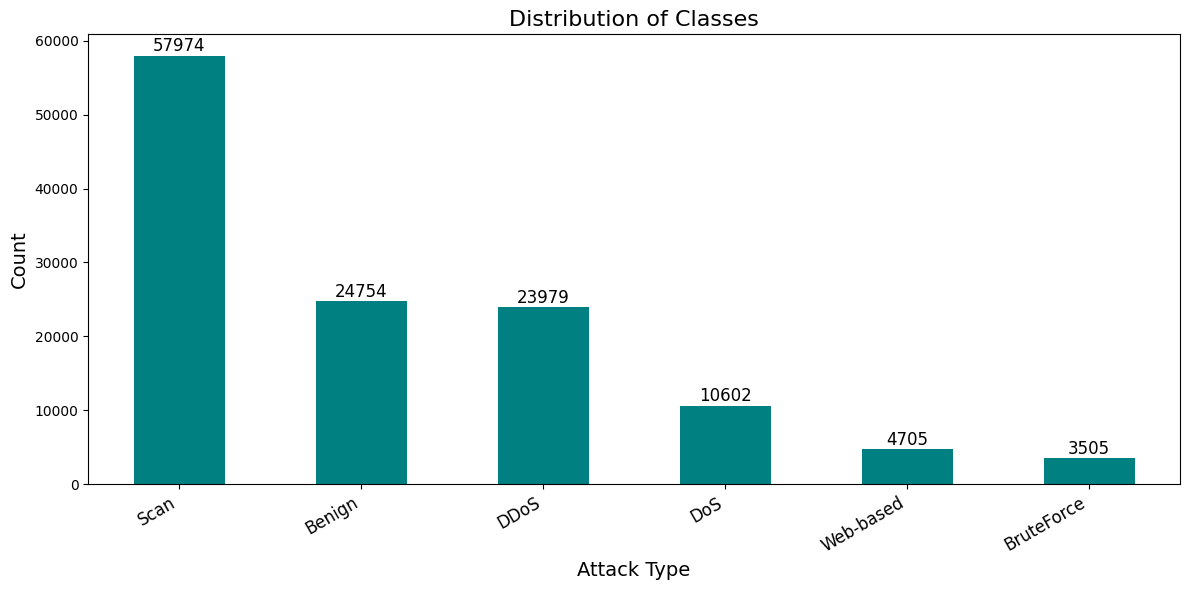

In [75]:
plt.figure(figsize=(12, 6))
value_counts = all_attacks_df['label'].value_counts()
ax = value_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Attack Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.tight_layout()

# Value labels
for i, v in enumerate(value_counts):
    ax.text(i, v + max(value_counts)*0.01, str(v), ha='center', fontsize=12)
plt.show()


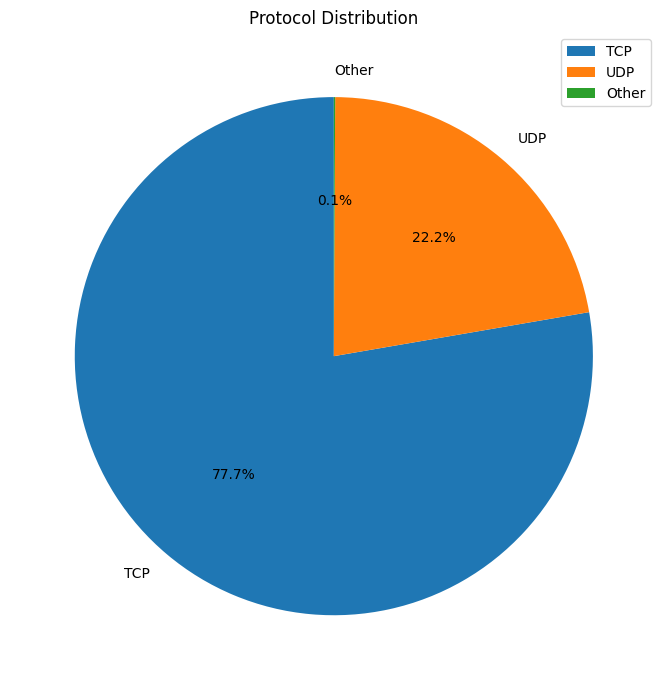

In [76]:
# Mapping protocol numbers to names
protocol_map = {6: 'TCP', 17: 'UDP', 0: 'Other'}

# Create a new column with protocol names (if not present)
if 'protocol_name' not in all_attacks_df.columns:
    all_attacks_df['protocol_name'] = all_attacks_df['protocol'].map(protocol_map).fillna('Other')

protocol_counts = all_attacks_df['protocol_name'].value_counts()

plt.figure(figsize=(7, 7))
patches, texts, autotexts = plt.pie(protocol_counts, labels=protocol_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Protocol Distribution')
plt.legend(patches, protocol_counts.index, loc="best")
plt.tight_layout()
plt.show()


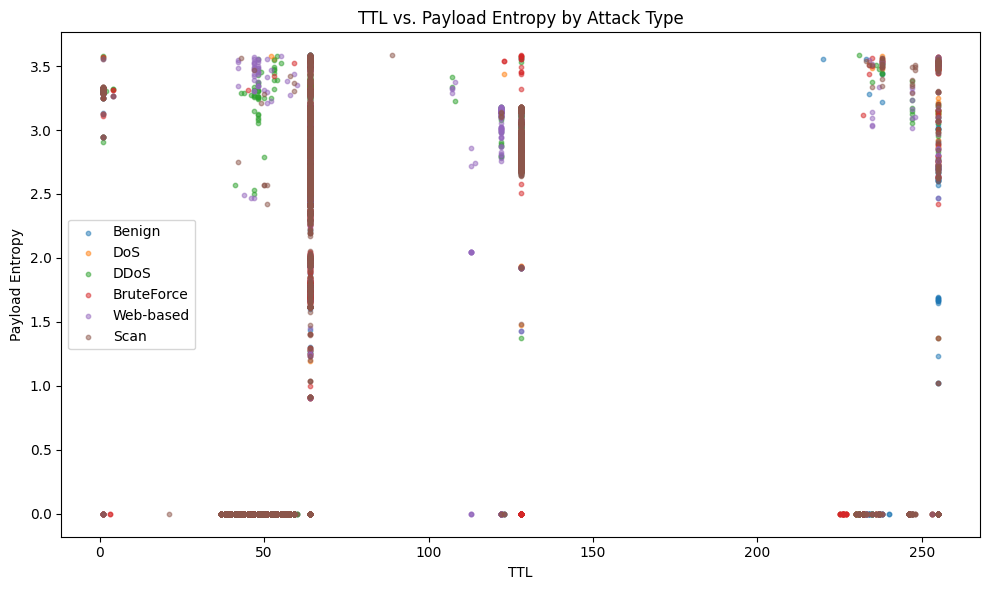

In [77]:
plt.figure(figsize=(10, 6))
labels = all_attacks_df['label'].unique()
colors = plt.cm.tab10.colors
for idx, label in enumerate(labels):
    subset = all_attacks_df[all_attacks_df['label'] == label]
    plt.scatter(subset['ttl'], subset['payload_entropy'], alpha=0.5, label=label, s=10, color=colors[idx % len(colors)])
plt.xlabel('TTL')
plt.ylabel('Payload Entropy')
plt.title('TTL vs. Payload Entropy by Attack Type')
plt.legend()
plt.tight_layout()
plt.show()


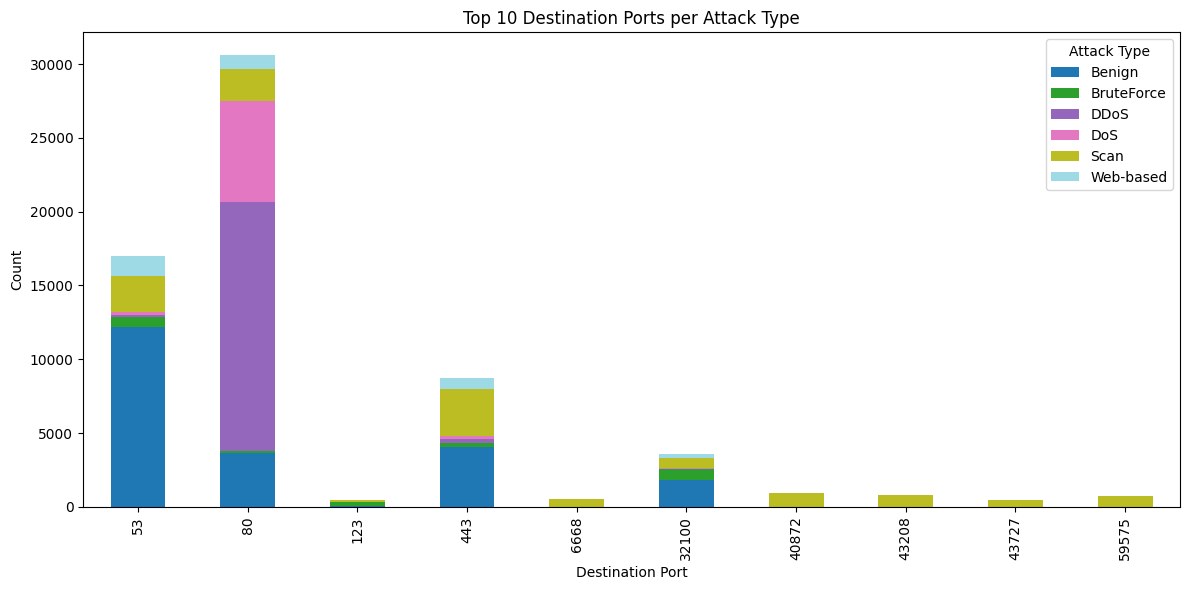

In [78]:
top_ports = all_attacks_df['dst_port'].value_counts().head(10).index
df_top_ports = all_attacks_df[all_attacks_df['dst_port'].isin(top_ports)]
pivot = pd.crosstab(df_top_ports['dst_port'], df_top_ports['label'])
pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Top 10 Destination Ports per Attack Type')
plt.xlabel('Destination Port')
plt.ylabel('Count')
plt.legend(title='Attack Type')
plt.tight_layout()
plt.show()


/tmp/ipython-input-989559574.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




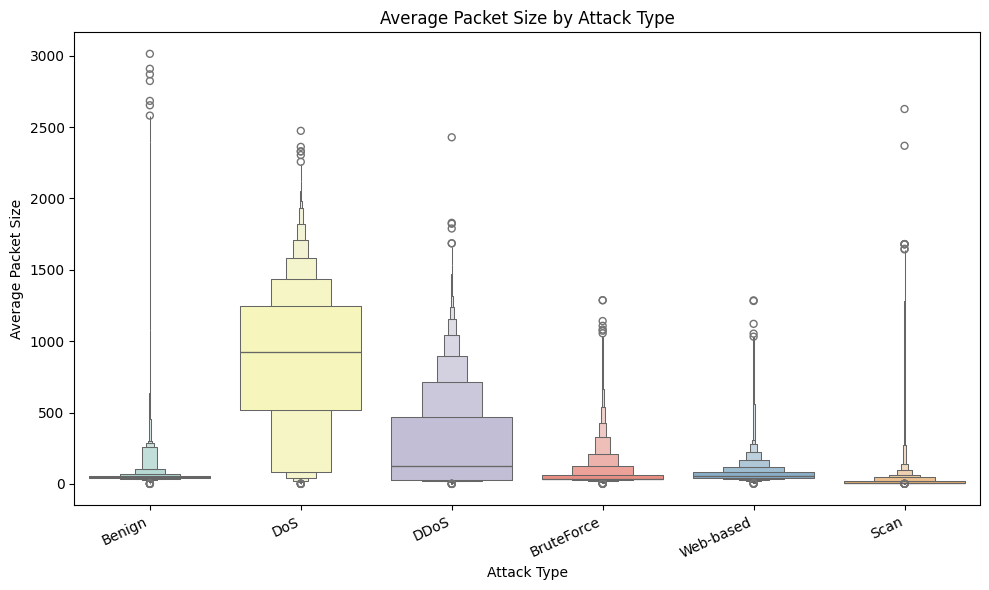

In [79]:
plt.figure(figsize=(10, 6))
sns.boxenplot(data=all_attacks_df, x='label', y='average_p', palette='Set3')
plt.title('Average Packet Size by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Average Packet Size')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


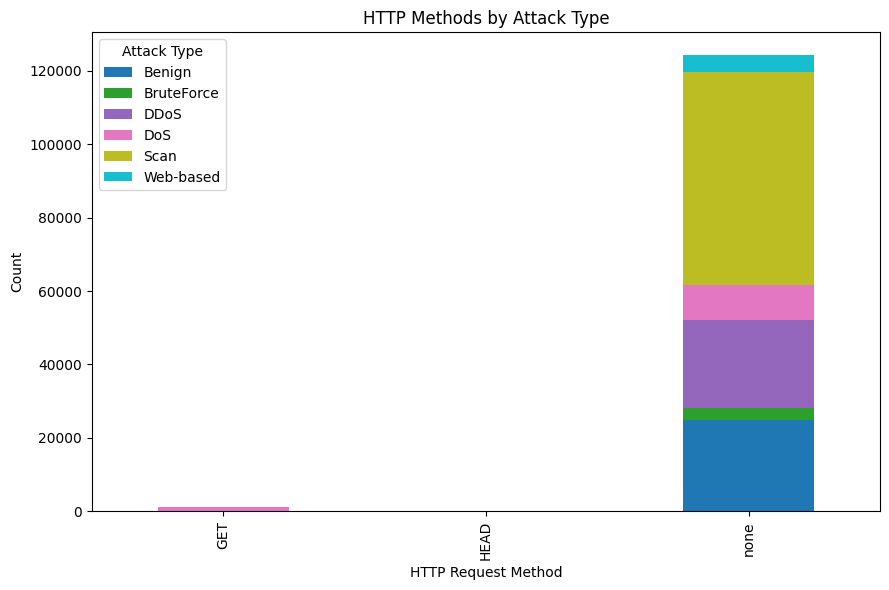

In [80]:
if 'http_request_method' in all_attacks_df.columns:
    methods = all_attacks_df['http_request_method'].value_counts().head(5).index
    df_http = all_attacks_df[all_attacks_df['http_request_method'].isin(methods)]
    crosstab = pd.crosstab(df_http['http_request_method'], df_http['label'])
    crosstab.plot(kind='bar', stacked=True, figsize=(9, 6), colormap='tab10')
    plt.title('HTTP Methods by Attack Type')
    plt.xlabel('HTTP Request Method')
    plt.ylabel('Count')
    plt.legend(title='Attack Type')
    plt.tight_layout()
    plt.show()


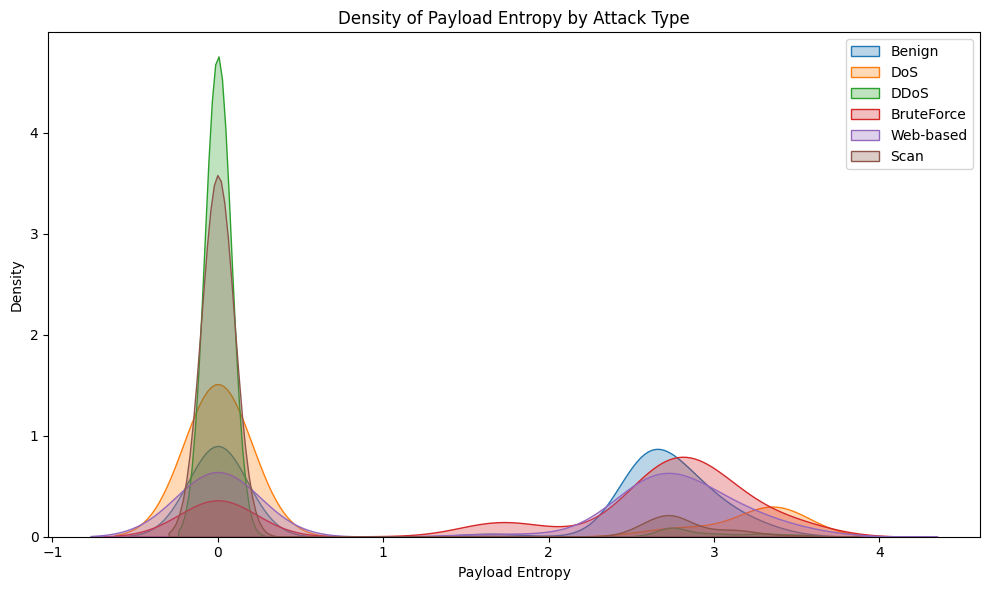

In [81]:
plt.figure(figsize=(10,6))
for label in all_attacks_df['label'].unique():
    subset = all_attacks_df[all_attacks_df['label']==label]
    sns.kdeplot(subset['payload_entropy'], label=label, fill=True, alpha=0.3)
plt.title('Density of Payload Entropy by Attack Type')
plt.xlabel('Payload Entropy')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-4209562205.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



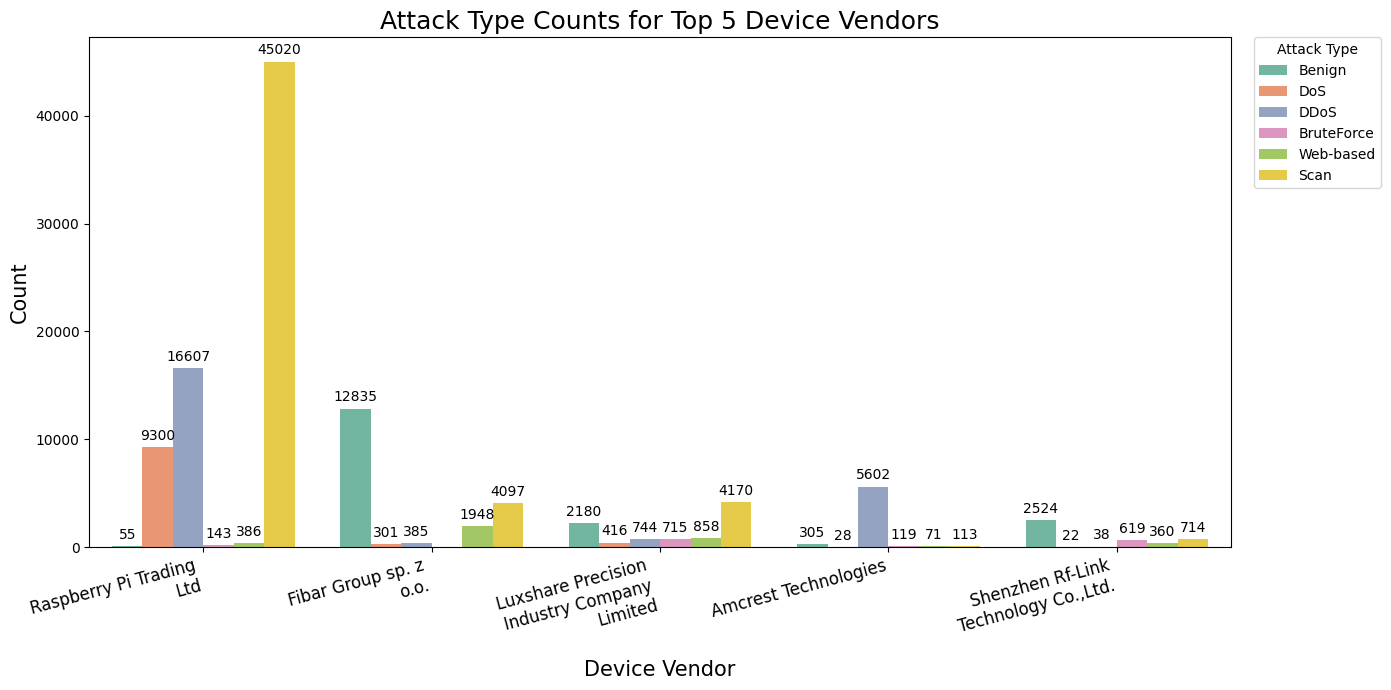

In [82]:
# Pick top 5 vendors
top_vendors = all_attacks_df['eth_src_oui'].value_counts().head(5).index
filtered = all_attacks_df[all_attacks_df['eth_src_oui'].isin(top_vendors)]

plt.figure(figsize=(14, 7))
ax = sns.countplot(
    data=filtered,
    x='eth_src_oui',
    hue='label',
    order=top_vendors,
    palette='Set2'
)

plt.title('Attack Type Counts for Top 5 Device Vendors', fontsize=18)
plt.xlabel('Device Vendor', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Wrap long vendor names for better display
labels = [textwrap.fill(label, 20) for label in top_vendors]
ax.set_xticklabels(labels, rotation=15, ha='right', fontsize=12)

# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, label_type='edge', padding=3)

plt.legend(title='Attack Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


In [83]:
fig = px.treemap(
    all_attacks_df,
    path=['eth_src_oui', 'label', 'protocol_name'],
    title="Treemap: Vendor → Attack → Protocol"
)
fig.show()


In [84]:
sun_df = filtered.copy()
sun_df['protocol_name'] = sun_df['protocol'].map(protocol_map).fillna('Other')

fig = px.sunburst(
    sun_df,
    path=['eth_src_oui', 'label', 'protocol_name'],
    title='Device Vendor → Attack Type → Protocol',
    maxdepth=3
)
fig.show()


In [85]:
for col in ['active mean', 'idle mean']:
    if col in all_attacks_df.columns:
        fig = px.box(
            all_attacks_df,
            x='label', y=col,
            color='label', points='all',
            title=f'{col.replace("_", " ").title()} by Attack Type'
        )
        fig.show()


In [86]:
if 'port_class_dst' in all_attacks_df.columns:
    port_attack = (
        all_attacks_df.groupby(['port_class_dst', 'label']).size().reset_index(name='count')
    )
    fig = px.bar(
        port_attack,
        x='port_class_dst', y='count', color='label',
        title='Attack Type by Destination Port Class',
        barmode='stack'
    )
    fig.show()


In [87]:
if 'highest_layer' in all_attacks_df.columns:
    layer_counts = (
        all_attacks_df.groupby(['highest_layer', 'label']).size().reset_index(name='count')
    )
    fig = px.bar(
        layer_counts,
        x='highest_layer', y='count', color='label',
        title='Highest Layer Protocol Distribution by Attack',
        barmode='group'
    )
    fig.update_xaxes(type='category', tickangle=-30)
    fig.show()


In [88]:
if 'var_p' in all_attacks_df.columns:
    fig = px.histogram(
        all_attacks_df,
        x='var_p', color='label',
        nbins=40,
        title='Packet Length Variance Distribution by Attack Type'
    )
    fig.update_xaxes(title='Variance of Packet Length')
    fig.update_yaxes(title='Count')
    fig.show()


In [89]:
srcip_attack = all_attacks_df.groupby('label')['src_ip'].nunique().reset_index()
fig = px.bar(
    srcip_attack,
    x='label', y='src_ip',
    title='Unique Source IPs per Attack Type',
    labels={'src_ip': 'Unique Source IP Count', 'label': 'Attack Type'}
)
fig.show()


## Temporal Analysis

In [90]:
df = all_attacks_df.copy()
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['hour'] = df['timestamp_dt'].dt.hour
df['day'] = df['timestamp_dt'].dt.date

# Group: count events per attack per hour
heatmap_data = df.groupby(['hour', 'label']).size().reset_index(name='count')

fig = px.density_heatmap(
    heatmap_data,
    x='hour', y='label', z='count',
    color_continuous_scale='Blues',
    title='Attack Activity Heatmap: Hour of Day vs. Attack Type'
)
fig.update_xaxes(dtick=1)
fig.show()


/tmp/ipython-input-284807913.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



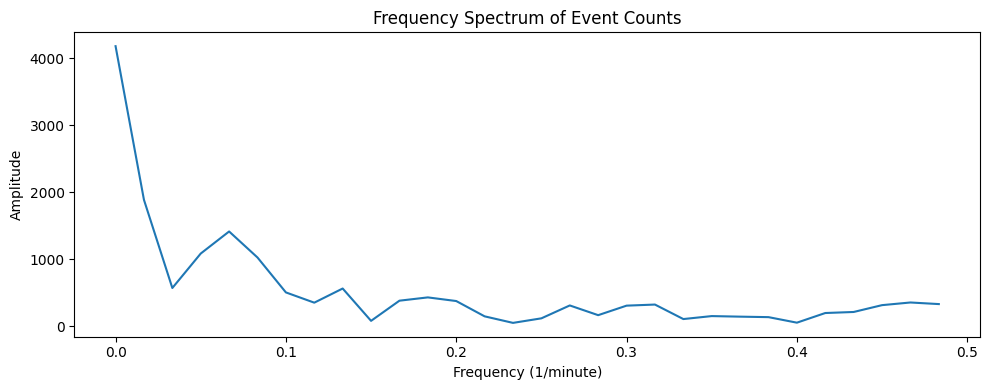

In [91]:
df['minute'] = df['timestamp_dt'].dt.minute

counts = df.groupby('minute').size().values
N = len(counts)
yf = fft(counts)
xf = fftfreq(N, 1)[:N//2]  # Frequency axis (1 per minute here)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Frequency Spectrum of Event Counts')
plt.xlabel('Frequency (1/minute)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


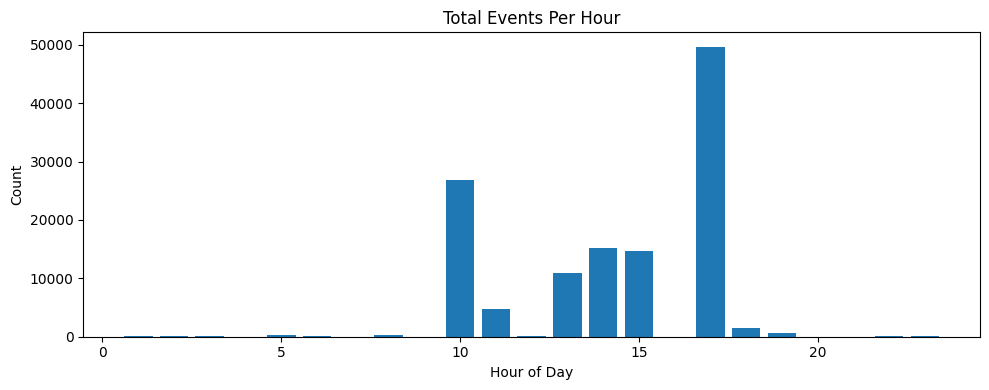

In [92]:
df['hour'] = df['timestamp_dt'].dt.hour
hourly = df.groupby('hour').size()

plt.figure(figsize=(10,4))
plt.bar(hourly.index, hourly.values)
plt.title('Total Events Per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Feature Engineering

In [93]:
all_attacks_df.shape

(125519, 204)

## Extracting Time Based Features

In [94]:
df = all_attacks_df.copy()
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['hour'] = df['timestamp_dt'].dt.hour
df['minute'] = df['timestamp_dt'].dt.minute
df['dayofweek'] = df['timestamp_dt'].dt.dayofweek  # 0=Monday
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['is_working_hour'] = df['hour'].between(8, 18).astype(int)

/tmp/ipython-input-3959021892.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [95]:
df.shape

(125519, 210)

## Dropping Columns With Only One Unique Value

In [96]:
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
print("One-unique-value columns:", one_value_cols)
df = df.drop(columns=one_value_cols)


One-unique-value columns: ['handshake_ciphersuites', 'http_host', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'urg flag count', 'fwd bytes/bulk avg', 'fwd packet/bulk avg', 'fwd bulk rate avg']


In [97]:
df.shape

(125519, 201)

In [98]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Print number of unique values and the unique values themselves
for col in cat_cols:
    unique_vals = df[col].unique()
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {len(unique_vals)}")
    # Print all if few, else just the first 20
    if len(unique_vals) <= 20:
        print("Unique values:", unique_vals)
    else:
        print("First 20 unique values:", unique_vals[:20])


Column: src_mac
Number of unique values: 80
First 20 unique values: ['Arlo Q Indoor Camera' 'HeimVision Smart WiFi Camera'
 'Nest Indoor Camera' 'ac:17:02:05:34:27' 'Teckin Plug 2'
 'Amazon Echo Show' 'Yutron Plug 2' 'GoSund Smart plug WP2 (1)'
 'Gosund Power strip (1)' 'GoSund Bulb' '24:05:88:30:6f:89'
 'Yi Indoor 2 Camera' 'Wyze Camera' '3c:18:a0:41:c3:a0' 'Yutron Plug 1'
 'Google Nest Mini Speaker' 'LIFX Lightbulb'
 'HeimVision SmartLife Radio/Lamp' 'e8:1b:69:f8:d4:e3' 'Lumiman bulb']

Column: dst_mac
Number of unique values: 83
First 20 unique values: ['3c:18:a0:41:c3:a0' '01:00:5e:7f:ff:fa' 'ff:ff:ff:ff:ff:ff'
 'Nest Indoor Camera' '01:00:5e:00:00:fb'
 'HeimVision SmartLife Radio/Lamp' 'Google Nest Mini Speaker'
 'Wyze Camera' '56:4f:8a:e1:f3:2d' 'ac:17:02:05:34:27' 'dc:a6:32:dc:27:d5'
 'Amazon Echo Dot 2' 'Rbcior Camera' 'SmartThings Hub'
 'Levoit Air Purifier' 'Amazon Echo Studio' 'Netatmo Camera'
 'Amazon Echo Dot 1' 'b0:09:da:3e:82:6c' 'Amazon Echo Show']

Column: src_ip
Numb

In [99]:
df_work = df.copy()
cat_cols = [col for col in df_work.select_dtypes(include=['object', 'category']).columns if col != 'label']
print("Categorical columns to encode:", cat_cols)

Categorical columns to encode: ['src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version', 'tls_server', 'http_request_method', 'user_agent', 'dns_server', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_type', 'timestamp', 'protocol_name']


In [100]:
cat_cols = [
    'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version', 'tls_server',
    'http_request_method', 'user_agent', 'dns_server', 'device_mac', 'eth_src_oui',
    'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_type', 'protocol_name'
]
# Drop timestamp column if present
if 'timestamp' in df_work.columns:
    df_work = df_work.drop('timestamp', axis=1)

# Label encode each categorical column
for col in cat_cols:
    if col in df_work.columns:
        le = LabelEncoder()
        df_work[col] = le.fit_transform(df_work[col].astype(str))


In [101]:
# Encode 'label' as the target
if 'label' in df_work.columns:
    df_work['target'] = LabelEncoder().fit_transform(df_work['label'])
    df_work = df_work.drop('label', axis=1)

In [102]:
# Drop all datetime columns if present
datetime_cols = df_work.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()
if datetime_cols:
    print("Dropping datetime columns:", datetime_cols)
    df_work = df_work.drop(columns=datetime_cols)


Dropping datetime columns: ['timestamp_dt']


In [103]:
df_work.shape

(125519, 199)

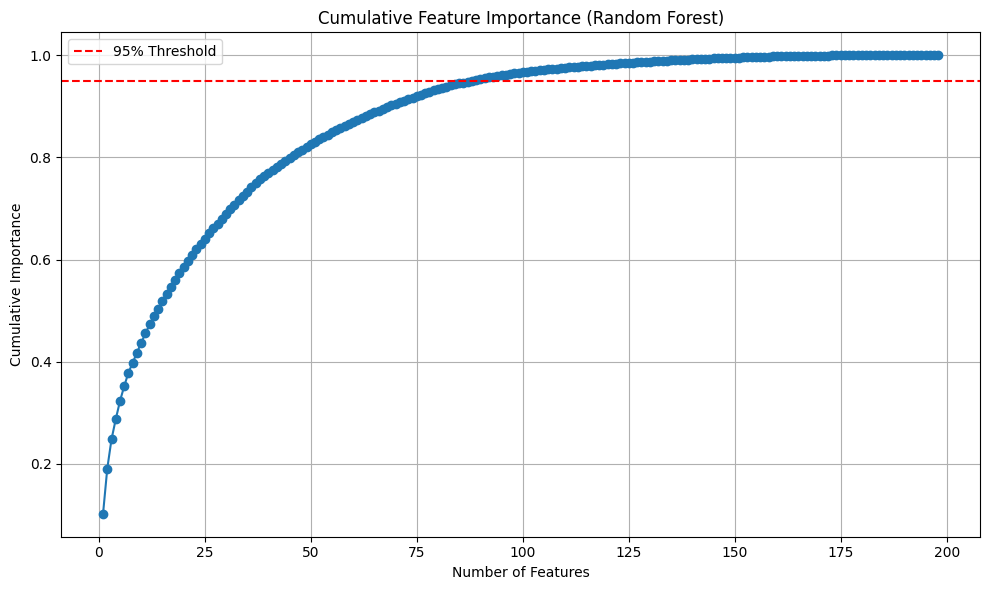


 Number of features to retain for 95% cumulative importance: 88
 Number of features above importance threshold 0.005: 51


In [104]:
# Define features and target
X = df_work.drop('target', axis=1)
y = df_work['target']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Convert to DataFrame
feat_imp_df = pd.DataFrame(feat_imp, columns=['feature', 'importance'])
feat_imp_df['cumulative_importance'] = feat_imp_df['importance'].cumsum()

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feat_imp_df)+1), feat_imp_df['cumulative_importance'], marker='o')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance (Random Forest)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Find number of features contributing to 95% importance
num_95 = feat_imp_df[feat_imp_df['cumulative_importance'] <= 0.95].shape[0] + 1
print(f"\n Number of features to retain for 95% cumulative importance: {num_95}")

# Apply threshold-based filtering
threshold = 0.005
important_features_thresh = feat_imp_df[feat_imp_df['importance'] >= threshold]['feature'].tolist()
print(f" Number of features above importance threshold {threshold}: {len(important_features_thresh)}")

# Reduce feature set based on both methods
top_features_95 = feat_imp_df.iloc[:num_95]['feature'].tolist()

# Prepare reduced feature sets
X_top95 = X[top_features_95]
X_thresh = X[important_features_thresh]


After SMOTE: Counter({np.int64(0): 57974, np.int64(3): 57974, np.int64(2): 57974, np.int64(1): 57974, np.int64(5): 57974, np.int64(4): 57974})
Expected feature count: 88
Feature names:
 ['dayofweek', 'hour', 'inter_arrival_time', 'is_weekend', 'l3_ip_dst_count', 'src_ip_30_mean', 'minute', 'src_ip_60_mean', 'src_ip_mac_60_mean', 'src_ip_mac_10_mean', 'most_freq_spot', 'q3_p', 'src_ip_5_mean', 'stream', 'src_ip_mac_30_mean', 'channel_30_var', 'channel_5_count', 'channel_5_mean', 'src_ip_10_mean', 'channel_30_count', 'src_ip_5_count', 'channel_60_mean', 'channel_10_count', 'channel_30_mean', 'channel_10_var', 'src_ip_1_count', 'channel_60_count', 'channel_60_var', 'src_ip_mac_1_count', 'channel_10_mean', 'src_ip_mac_30_var', 'channel_1_count', 'stream_30_mean', 'med_p', 'src_ip_10_count', 'src_ip_mac_5_mean', 'channel_1_mean', 'src_ip_mac_60_var', 'stream_jitter_60_mean', 'sum_p', 'src_ip_1_mean', 'stream_5_mean', 'stream_jitter_10_sum', 'ttl', 'src_ip_30_count', 'src_ip_mac_10_count', '

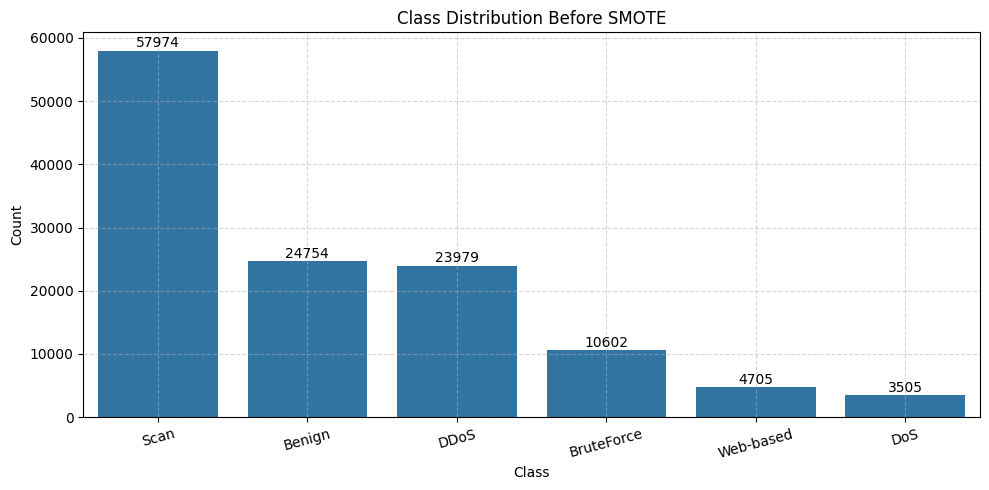

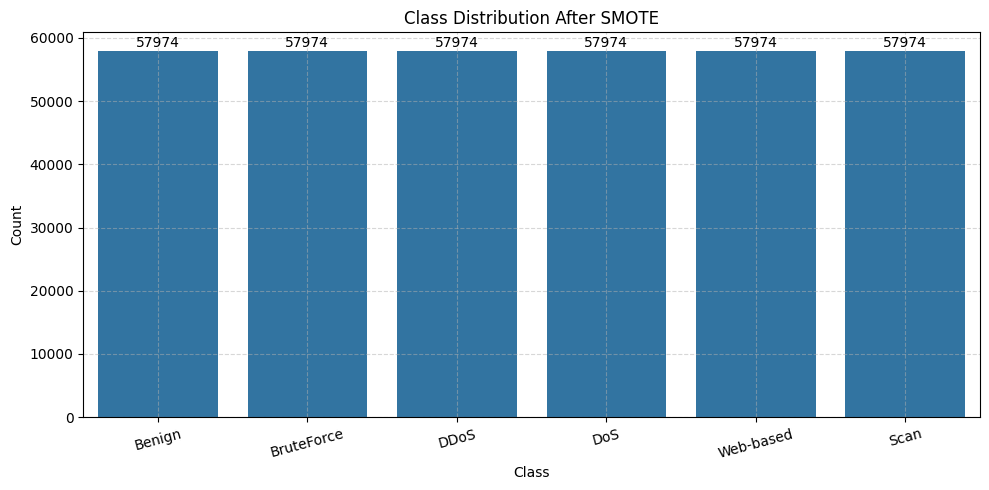

In [120]:
# Input and label
X = X_top95.values
y_raw = y.values
num_classes = len(np.unique(y_raw))

# Apply SMOTE before splitting
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_raw)
print("After SMOTE:", Counter(y_resampled))

# Train-test split on balanced data
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Save test data to CSV for row-wise prediction later
X_test_df = pd.DataFrame(X_test, columns=top_features_95)
X_test_df['target'] = y_test_raw

print("Expected feature count:", len(top_features_95))
print("Feature names:\n", top_features_95)

# Save to CSV
X_test_df.to_csv("/content/drive/MyDrive/iot_dataset/X_test_for_prediction.csv", index=False)
print("Test data saved as CSV for future predictions.")



# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, "/content/drive/MyDrive/iot_dataset/scaler.pkl")
print("Scaler saved as scaler.pkl")


# One-hot encode target
y_train = to_categorical(y_train_raw, num_classes)
y_test = to_categorical(y_test_raw, num_classes)

label_map = {
    0: "Benign",
    1: "DoS",
    2: "DDoS",
    3: "BruteForce",
    4: "Scan",
    5: "Web-based"
}

# ----------- Before SMOTE -----------
before_counts = pd.Series(Counter(y_raw)).sort_values(ascending=False)

# Map integer labels to class names if needed
try:
    before_counts.index = before_counts.index.map(label_map)
except:
    pass

plt.figure(figsize=(10, 5))
sns.barplot(x=before_counts.index, y=before_counts.values)
for i, v in enumerate(before_counts.values):
    plt.text(i, v + 500, str(v), ha='center')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ----------- After SMOTE -----------
after_counts = pd.Series(Counter(y_resampled)).sort_values(ascending=False)

try:
    after_counts.index = after_counts.index.map(label_map)
except:
    pass

plt.figure(figsize=(10, 5))
sns.barplot(x=after_counts.index, y=after_counts.values)
for i, v in enumerate(after_counts.values):
    plt.text(i, v + 500, str(v), ha='center')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Model Training

## Applying CNN

In [106]:
# ----- Reshape Input -----
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ----- Define CNN Model -----
cnn_model = Sequential([
    Conv1D(8, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# ----- Early Stopping -----
X_train_cnn = X_train_cnn + np.random.normal(0, 0.3, X_train_cnn.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ----- Train Model -----
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8368 - loss: 0.7634 - val_accuracy: 0.9662 - val_loss: 0.1652
Epoch 2/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9341 - loss: 0.2763 - val_accuracy: 0.9674 - val_loss: 0.1556
Epoch 3/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9364 - loss: 0.2674 - val_accuracy: 0.9701 - val_loss: 0.1491
Epoch 4/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9358 - loss: 0.2665 - val_accuracy: 0.9668 - val_loss: 0.1586
Epoch 5/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9360 - loss: 0.2664 - val_accuracy: 0.9657 - val_loss: 0.1607
Epoch 6/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9358 - loss: 0.2654 - val_accuracy: 0.9693 - val_loss: 0.1538


## Applying LSTM

In [107]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM model
lstm_model = Sequential([
    LSTM(16, return_sequences=False, input_shape=(1, X_train.shape[1])),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
X_train_lstm = X_train_lstm + np.random.normal(0, 0.3, X_train_lstm.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7285 - loss: 0.7191 - val_accuracy: 0.9736 - val_loss: 0.0714
Epoch 2/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8987 - loss: 0.2691 - val_accuracy: 0.9857 - val_loss: 0.0427
Epoch 3/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9120 - loss: 0.2338 - val_accuracy: 0.9879 - val_loss: 0.0368
Epoch 4/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9178 - loss: 0.2174 - val_accuracy: 0.9877 - val_loss: 0.0368
Epoch 5/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9217 - loss: 0.2073 - val_accuracy: 0.9898 - val_loss: 0.0311
Epoch 6/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9253 - loss: 0.2000 - val_accuracy: 0.9898 - val_loss: 0.0308
Epoch 7/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9285 - loss: 0.1914 - val_accuracy: 0.9908 - val_loss: 0.0285
Epoch 8/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9304 - loss: 0.1894 - 

## Applying Conv-LSTM Model

In [108]:
# Set timestep and calculate features per timestep
timesteps = 4
feature_dim = X_train.shape[1] // timesteps

# Ensure the number of features divides evenly by timesteps
X_train_conv = X_train[:, :timesteps * feature_dim].reshape((X_train.shape[0], timesteps, feature_dim))
X_test_conv = X_test[:, :timesteps * feature_dim].reshape((X_test.shape[0], timesteps, feature_dim))


# Conv-LSTM architecture
conv_lstm_model = Sequential([
    TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(timesteps, feature_dim, 1)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Dropout(0.3)),

    TimeDistributed(Conv1D(128, 3, activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Dropout(0.3)),

    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Reshape input to (samples, timesteps, features, 1) for Conv1D inside TimeDistributed
X_train_convlstm = X_train_conv.reshape((X_train_conv.shape[0], timesteps, feature_dim, 1))
X_test_convlstm = X_test_conv.reshape((X_test_conv.shape[0], timesteps, feature_dim, 1))

# Compile model
conv_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_convlstm = conv_lstm_model.fit(
    X_train_convlstm, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3044/3044 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.9238 - loss: 0.2361 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 2/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.9954 - loss: 0.0174 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 3/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.9997 - val_loss: 0.0017
Epoch 4/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 0.9998 - val_loss: 9.9414e-04
Epoch 5/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 6/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9998 - val_loss: 7.6805e-04
Epoch 7/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 8/10
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.9988 - lo

# Results

In [109]:
def evaluate_model(model, X_test, y_test, label_map, history=None, model_name="Model"):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"\n==== Evaluation Report for {model_name} ====\n")
    report = classification_report(y_true, y_pred, target_names=list(label_map.values()), output_dict=True)
    print(classification_report(y_true, y_pred, target_names=list(label_map.values())))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_map.values()),
                yticklabels=list(label_map.values()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Plot training history
    if history:
        plt.figure(figsize=(14, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} - Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    metrics = {
        'accuracy': report['accuracy'],
        'precision_macro': np.mean([report[cls]['precision'] for cls in label_map.values()]),
        'recall_macro': np.mean([report[cls]['recall'] for cls in label_map.values()]),
        'f1_macro': np.mean([report[cls]['f1-score'] for cls in label_map.values()])
    }
    return metrics


## CNN Results

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step

==== Evaluation Report for CNN ====

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     11594
         DoS       1.00      0.92      0.96     11595
        DDoS       1.00      1.00      1.00     11595
  BruteForce       1.00      0.99      0.99     11595
        Scan       1.00      0.94      0.97     11595
   Web-based       0.87      1.00      0.93     11595

    accuracy                           0.97     69569
   macro avg       0.98      0.97      0.97     69569
weighted avg       0.98      0.97      0.97     69569



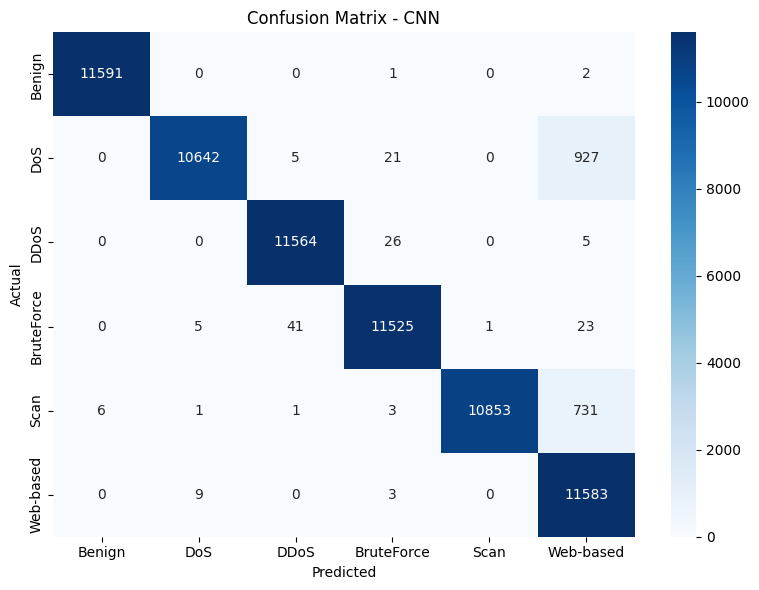

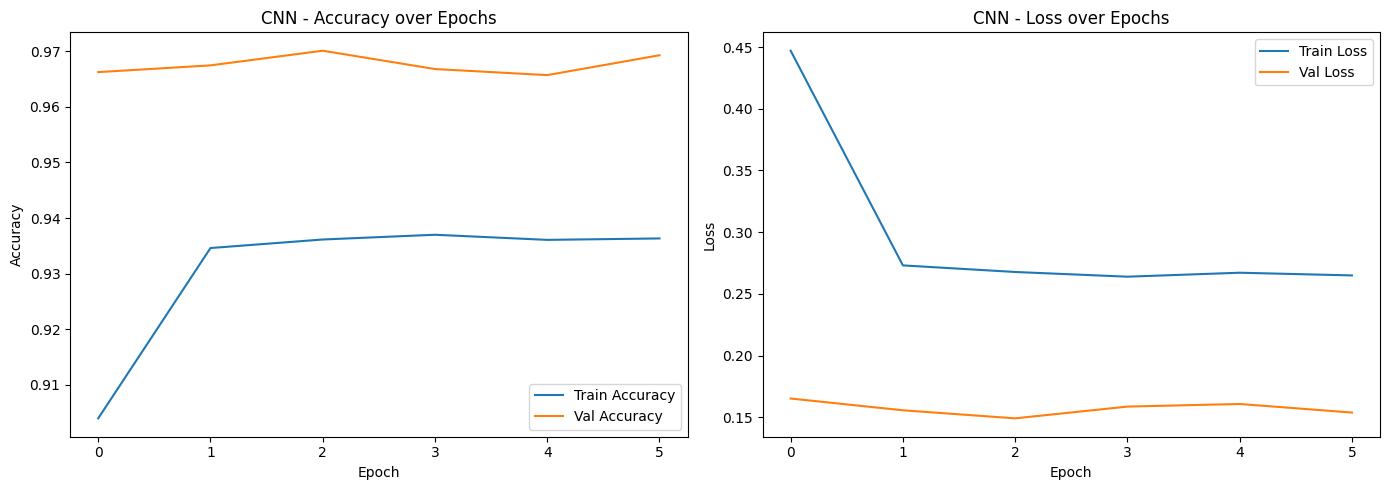


Summary Metrics: {'accuracy': 0.9739682904742054, 'precision_macro': np.float64(0.9770128052674099), 'recall_macro': np.float64(0.9739686609349644), 'f1_macro': np.float64(0.9743224166727046)}


In [110]:
cnn_metrics = evaluate_model(
    model=cnn_model,
    X_test=X_test_cnn,
    y_test=y_test,
    label_map=label_map,
    history=history,
    model_name="CNN"
)

print("\nSummary Metrics:", cnn_metrics)

## LSTM Results

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step

==== Evaluation Report for LSTM ====

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     11594
         DoS       1.00      0.99      0.99     11595
        DDoS       1.00      1.00      1.00     11595
  BruteForce       1.00      1.00      1.00     11595
        Scan       1.00      1.00      1.00     11595
   Web-based       0.99      1.00      0.99     11595

    accuracy                           1.00     69569
   macro avg       1.00      1.00      1.00     69569
weighted avg       1.00      1.00      1.00     69569



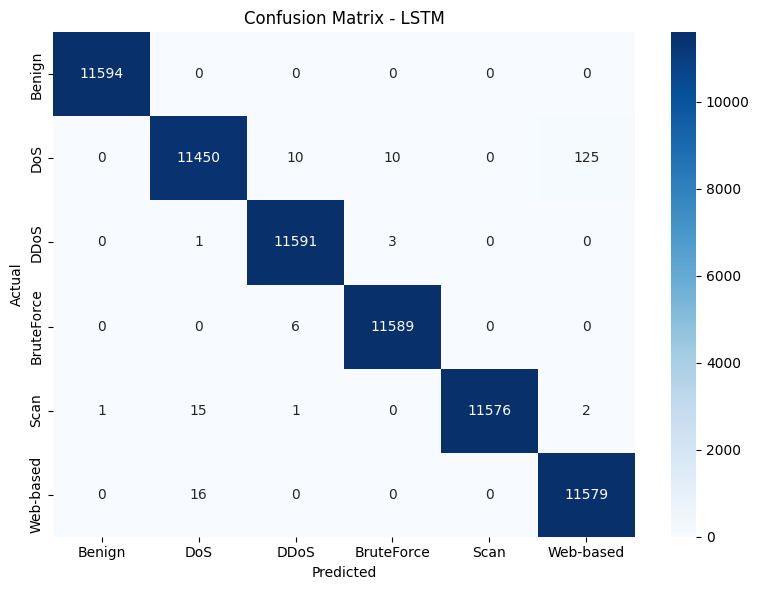

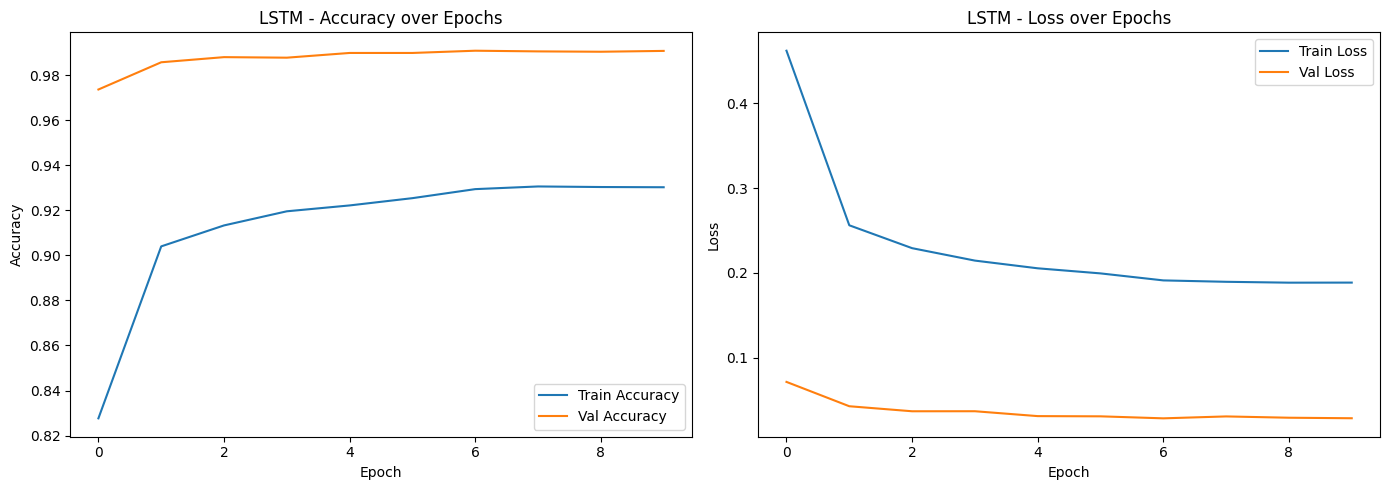


Summary Metrics (LSTM): {'accuracy': 0.9972688985036439, 'precision_macro': np.float64(0.9972821073535286), 'recall_macro': np.float64(0.9972689377605292), 'f1_macro': np.float64(0.9972676181153082)}


In [111]:
lstm_metrics = evaluate_model(
    model=lstm_model,
    X_test=X_test_lstm,
    y_test=y_test,
    label_map=label_map,
    history=history_lstm,
    model_name="LSTM"
)

print("\nSummary Metrics (LSTM):", lstm_metrics)


## Conv-LSTM Results

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

==== Evaluation Report for Conv-LSTM ====

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     11594
         DoS       1.00      1.00      1.00     11595
        DDoS       1.00      1.00      1.00     11595
  BruteForce       1.00      1.00      1.00     11595
        Scan       1.00      1.00      1.00     11595
   Web-based       1.00      1.00      1.00     11595

    accuracy                           1.00     69569
   macro avg       1.00      1.00      1.00     69569
weighted avg       1.00      1.00      1.00     69569



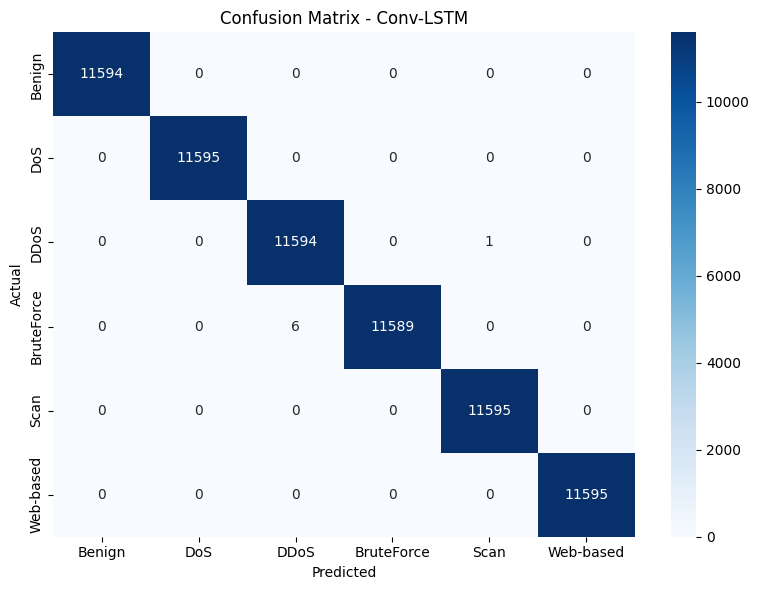

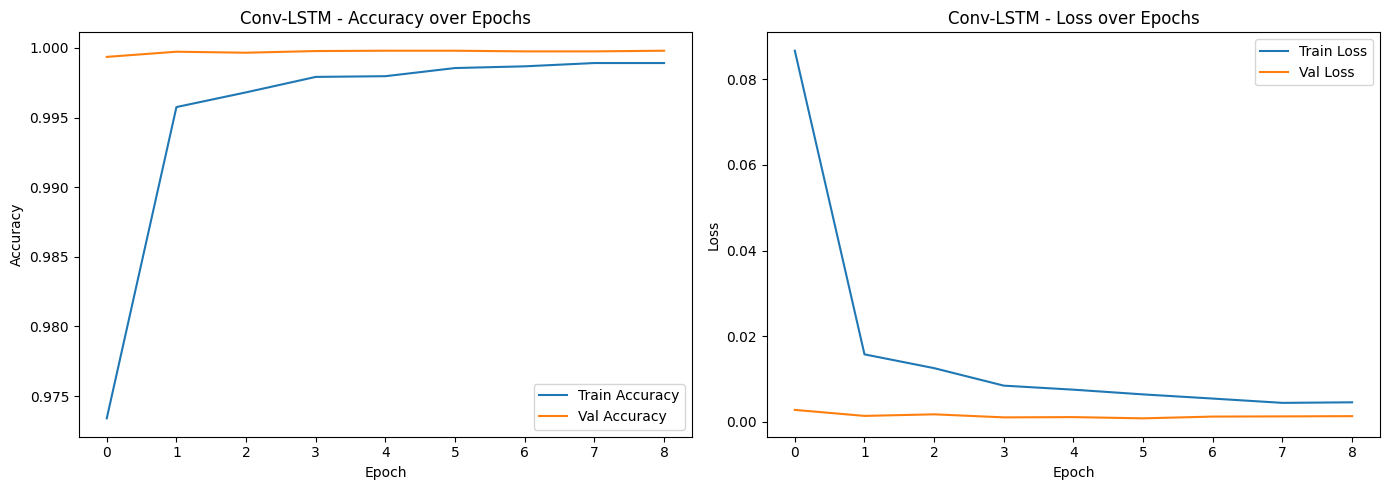


Summary Metrics (Conv-LSTM): {'accuracy': 0.9998993804711869, 'precision_macro': np.float64(0.999899420331228), 'recall_macro': np.float64(0.9998993819174932), 'f1_macro': np.float64(0.9998993819122542)}


In [112]:
convlstm_metrics = evaluate_model(
    model=conv_lstm_model,
    X_test=X_test_convlstm,
    y_test=y_test,
    label_map=label_map,
    history=history_convlstm,
    model_name="Conv-LSTM"
)

print("\nSummary Metrics (Conv-LSTM):", convlstm_metrics)


## Comparison of Accuracy

In [113]:
# Create a DataFrame of model names and final accuracies
accuracy_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Conv-LSTM'],
    'Accuracy': [
        cnn_metrics['accuracy'],
        lstm_metrics['accuracy'],
        convlstm_metrics['accuracy']
    ]
})

# Plot using Plotly
fig = px.bar(
    accuracy_df,
    x='Model',
    y='Accuracy',
    color='Model',
    text='Accuracy',
    title='Overall Test Accuracy Comparison',
    template='plotly_white',
    color_discrete_sequence=['#FF6F91', '#FFC75F', '#008F7A']
)

fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis=dict(range=[0, 1.05]))
fig.show()


## Comparison of Precision Score

In [114]:
# Prepare precision data
precision_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Conv-LSTM'],
    'Precision': [
        cnn_metrics['precision_macro'],
        lstm_metrics['precision_macro'],
        convlstm_metrics['precision_macro']
    ]
})

# Plot horizontal bar chart
fig = px.bar(
    precision_df,
    y='Model',
    x='Precision',
    color='Model',
    orientation='h',
    text='Precision',
    title='Macro-Averaged Precision Comparison',
    template='plotly_white',
    color_discrete_sequence=['#FF6F91', '#FFC75F', '#008F7A']
)

fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(xaxis=dict(range=[0, 1.05]))
fig.show()


## Comparison of Recall Score

In [115]:
# Precision values
recall_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Conv-LSTM'],
    'Recall': [
        cnn_metrics['recall_macro'],
        lstm_metrics['recall_macro'],
        convlstm_metrics['recall_macro']
    ]
})

# Plot with Y-axis zoomed in
fig = px.line(
    recall_df,
    x='Model',
    y='Recall',
    markers=True,
    text='Recall',
    title='Macro-Averaged Recall Comparison',
    template='plotly_white'
)

fig.update_traces(texttemplate='%{text:.4f}', textposition='top center')

# Set y-axis range to zoom in
fig.update_layout(
    yaxis=dict(range=[0.970, 1.002]),
    xaxis_title='Model',
    yaxis_title='Recall'
)

fig.show()


## Comparison of F1-Score

In [116]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['CNN', 'LSTM', 'Conv-LSTM'],
    y=[cnn_metrics['f1_macro'], lstm_metrics['f1_macro'], convlstm_metrics['f1_macro']],
    mode='markers+text',
    marker=dict(size=14, color='crimson'),
    text=[f'{v:.4f}' for v in [cnn_metrics['f1_macro'], lstm_metrics['f1_macro'], convlstm_metrics['f1_macro']]],
    textposition='top center',
    name='F1 Score'
))

# Add lines from x-axis to dots (like sticks)
for i, score in enumerate([cnn_metrics['f1_macro'], lstm_metrics['f1_macro'], convlstm_metrics['f1_macro']]):
    fig.add_shape(type="line",
                  x0=i, y0=0, x1=i, y1=score,
                  line=dict(color="LightGray", width=2))

fig.update_layout(
    title='Macro-Averaged F1 Score Comparison (Lollipop Chart)',
    xaxis=dict(title='Model', tickvals=[0, 1, 2], ticktext=['CNN', 'LSTM', 'Conv-LSTM']),
    yaxis=dict(title='F1 Score', range=[0.9, 1.01]),
    template='plotly_white'
)

fig.show()


## Comparison of All models with all Performance Metrics

In [117]:
# Prepare DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'] * 3,
    'Value': (
        [cnn_metrics['accuracy'], cnn_metrics['precision_macro'], cnn_metrics['recall_macro'], cnn_metrics['f1_macro']] +
        [lstm_metrics['accuracy'], lstm_metrics['precision_macro'], lstm_metrics['recall_macro'], lstm_metrics['f1_macro']] +
        [convlstm_metrics['accuracy'], convlstm_metrics['precision_macro'], convlstm_metrics['recall_macro'], convlstm_metrics['f1_macro']]
    ),
    'Model': ['CNN'] * 4 + ['LSTM'] * 4 + ['Conv-LSTM'] * 4
})

# Plot
fig = px.bar(
    comparison_df,
    x='Metric',
    y='Value',
    color='Model',
    barmode='group',
    text='Value',
    title='Grouped Bar Chart: Model Comparison Across Metrics',
    template='plotly_white',
     color_discrete_sequence=['#364F6B', '#3FC1C9', '#FC5185']
)
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis=dict(range=[0.8, 1.01]))
fig.show()


# Saving the Best Performing Model

In [118]:
conv_lstm_model.save("/content/drive/MyDrive/iot_dataset/conv_lstm_model.keras")

# Performing Prediction

In [123]:
# --- Load scaler and model ---
scaler = joblib.load("/content/drive/MyDrive/iot_dataset/scaler.pkl")
model = load_model("/content/drive/MyDrive/iot_dataset/conv_lstm_model.keras")

raw_input_row = np.array([
    0.0,13.0,109.4081410998186,0.0,5.0,1370.5984009866374,26.0,1326.246693765529,1326.246693765529,1344.2101526579636,80.0,899.5876512568672,1329.2666454001514,3965.613844342997,1370.5984009866374,824716.5555028658,3196.140516033263,1266.1030974952282,1344.2101526579636,21198.740203399146,2222.8285879765035,1259.1874153477252,6717.692217149834,1279.2342917789977,842112.4229640174,376.30545553051604,43133.90134893577,808545.3793912163,376.30545553051604,1263.8780489727847,812579.4722523626,574.5938208019534,366.30985545346294,169.33609680439497,4800.506648149223,1329.2666454001514,1207.871294874056,808705.6467504917,151.443867375,9910.512707772363,1255.391049279767,366.30985545346294,181.0705915,64.0,15280.595287442935,4800.506648149223,839989.1183534544,0.6274500339696598,180.513882499,73.0,150.651187375,48.0,863091.1074174312,2222.8285879765035,1255.391049279767,181.840305,1.5819864460621875,242.0,30267.009151091854,849296.8271939433,5.134904185688125,63.165912000000006,15280.595287442935,366.30985545346294,148.474659,31879871.60608815,30267.009151091854,151.037109125,655.8495308597508,655.8495308597509,366.30985545346294,366.30985545346294,366.30985545346294,182.95855749999998,64240.0,3554974.7723567956,650459.1076268419,174.1129300005,150.269883,64256.0,12568.253069358258,19.0,892408.5182163384,849296.8271939433,808705.6467504917,0.9545364120925278,0.0,495.52563538861807
]).reshape(1, -1)  # shape: (1, 88)

scaled_input = scaler.transform(raw_input_row)

# --- Reshape for Conv-LSTM input ---
timesteps = 4
feature_dim = scaled_input.shape[1] // timesteps
reshaped_input = scaled_input[:, :timesteps * feature_dim].reshape(1, timesteps, feature_dim, 1)

# --- Predict ---
pred = model.predict(reshaped_input)
pred_class = np.argmax(pred, axis=1)[0]

# --- Map to label ---
label_map = {
    0: "Benign",
    1: "DoS",
    2: "DDoS",
    3: "BruteForce",
    4: "Scan",
    5: "Web-based"
}

print("Predicted class:", label_map.get(pred_class, "Unknown"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predicted class: BruteForce
